In [10]:
import pickle
import torch
import numpy as np
import sbibm
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from pathlib import Path

from sbi.inference import MNLE

# Plotting settings
plt.style.use('../plotting_settings.mplstyle')
# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# Fix seed for figures.
seed = 223174 #torch.randint(1000000, (1,))
torch.manual_seed(seed)
print(f"seed {seed}")

BASE_DIR = Path.cwd().parent.parent.as_posix()
data_folder = BASE_DIR + "/data/"
model_folder = BASE_DIR + "/notebooks/mnle-lan-comparison/models/"
save_folder = BASE_DIR + "/data/results/"

seed 223174


In [11]:
# Load pre-simulated training data
with open(data_folder + "ddm_training_and_test_data_10mio.p", "rb") as fh:
    theta, x_1d, xos_1d, thos = pickle.load(fh).values()

num_simulations = 10_000

theta = theta[:num_simulations]

# encode x as (time, choice)
x = torch.zeros((num_simulations, 2))
x[:, 0] = abs(x_1d[:num_simulations, 0])
x[x_1d[:num_simulations, 0] > 0, 1] = 1

# encode xos as (time, choice)
xos = torch.zeros((xos_1d.shape[0], 2))
xos[:, 0] = abs(xos_1d[:, 0])
xos[xos_1d[:, 0] > 0, 1] = 1

## Calculate metrics from pre-trained models

In [12]:
# load one pre-trained model
with open(model_folder + "mnle_n10000_seed41017.p", "rb") as fh:
    mnle, num_simulations = pickle.load(fh).values()

In [13]:
seed = torch.randint(100000, (1,)).item()

task = sbibm.get_task("ddm")
prior = task.get_prior_dist()
simulator = task.get_simulator(seed=seed) # Passing the seed to Julia.

### Show single likelihood

In [14]:
# Sample one parameter from the prior for a likelihood example.
theta_o = prior.sample((1,))
l_lower_bound = 1e-7
theta_o

tensor([[-0.4356,  1.7878,  0.5795,  0.5698]])

In [15]:
# RT range
test_tmax = 5
# Number of test points
ntest = 1000
rs = torch.cat((torch.linspace(test_tmax, l_lower_bound, ntest//2), 
           torch.linspace(l_lower_bound, test_tmax, ntest//2))).reshape(-1, 1)
cs = torch.cat((torch.zeros(ntest//2), 
           torch.ones(ntest//2))).reshape(-1, 1)

test_x = torch.hstack((rs, cs))
test_rts = torch.linspace(-test_tmax, test_tmax, ntest)

In [16]:
# get NLE synthetic likelihood for each data point with fixed theta.
lps_mnle = mnle.log_prob(test_x, theta_o.repeat(test_x.shape[0], 1)).detach()

# from analytical likelihood
lps_true = torch.tensor([task.get_log_likelihood(theta_o, d.reshape(-1, 1), l_lower_bound=l_lower_bound) 
                     for d in test_rts])


/home/janfb/.local/lib/python3.7/site-packages/julia/core.py:691: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  FutureWarning,


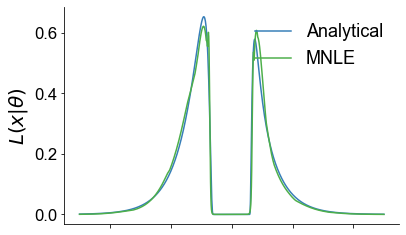

In [18]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["Analytical", 
          "MNLE", 
         ]
xticks = np.arange(-4, 5, 2)

plt.plot(test_rts, lps_true.exp(), label="Analytical L", c=colors[0]);
plt.plot(test_rts, lps_mnle.exp(), label="MNLE", ls="-", c=colors[2]);
plt.ylabel(r"$L(x | \theta)$");
plt.legend(labels)
plt.xticks(xticks, []);

### Systematic comparison

In [19]:
# Define losses.
def huber_loss(y, yhat):
    diff = abs(y-yhat)
    
    err = np.zeros(y.numel())
    err[diff <= 1.0] = 0.5 * diff[diff <= 1.0]**2
    err[diff > 1.0] = 0.5 + diff[diff > 1.0]
    return err.mean()

def mean_squared_error(y, yhat):
    return torch.mean((y - yhat)**2)

In [20]:
def score_mnle(path_to_model, num_observations, num_thetas_per_observation):

    # load model
    with open(path_to_model, "rb") as fh:
        mnle, num_simulations = pickle.load(fh).values()

    errors = []
    for idx in range(num_observations):
        # Sample test thetas from prior.
        test_thetas = thos[idx][:num_thetas_per_observation]
        xoi = xos_1d[idx].reshape(-1, 1)
        
        # Evaluate
        lps_mnle_i = mnle.log_prob(xos[idx].repeat(num_thetas_per_observation, 1), test_thetas).detach()
        lps_true_i = task.get_log_likelihood(test_thetas, data=xoi.reshape(1, -1), l_lower_bound=l_lower_bound)

        # Score
        errors.append([
            huber_loss(lps_mnle_i, lps_true_i),
            huber_loss(lps_mnle_i.exp(), lps_true_i.exp()),
            mean_squared_error(lps_mnle_i, lps_true_i),
            mean_squared_error(lps_mnle_i.exp(), lps_true_i.exp()),
            ])

    return np.array(errors)


## TODO: write function for LAN scoring
    # lps_lanana_i = lan_likelihood(test_thetas, xoi, lan_ana, np.log(l_lower_bound))
    # lps_lankde_i = lan_likelihood(test_thetas, xoi, lan_kde, np.log(l_lower_bound))


### Calculate metrics for every trained model (~5min per budget)

In [23]:
num_workers = 5
num_observations = 1000
num_thetas_per_observation = 10000

# set budget for which to calculate
budget = 10000
model_folder = Path.cwd() / "mnle-lan-comparison" / "models"  # Pathlib object
model_paths = list(model_folder.glob(f"*n{budget}_*"))

results = Parallel(n_jobs=num_workers)(
    delayed(score_mnle)(model_path, num_observations, num_thetas_per_observation) for model_path in model_paths
)

with open(f"mnle_likelihood_metrics_n{budget}.p", "wb") as fh:
    pickle.dump(dict(
        results=np.array(results),
        num_observations=num_observations, 
        num_thetas_per_observation=num_thetas_per_observation, 
        model_paths=model_paths), fh)


In [34]:
with open(save_folder + "mnle_likelihood_metrics_n10000.p", "rb") as fh:
    results_10k, num_observations, num_thetas_per_observation, model_paths = pickle.load(fh).values()

with open(save_folder + "mnle_likelihood_metrics_n100000.p", "rb") as fh:
    results_100k, num_observations, num_thetas_per_observation, model_paths = pickle.load(fh).values()

In [35]:
metrics = []

for ii in range(4):
    metrics.append(np.vstack((results_10k.mean(1)[:, ii], results_100k.mean(1)[:, ii])).T)

metrics = np.array(metrics)

### Simple comparison plot

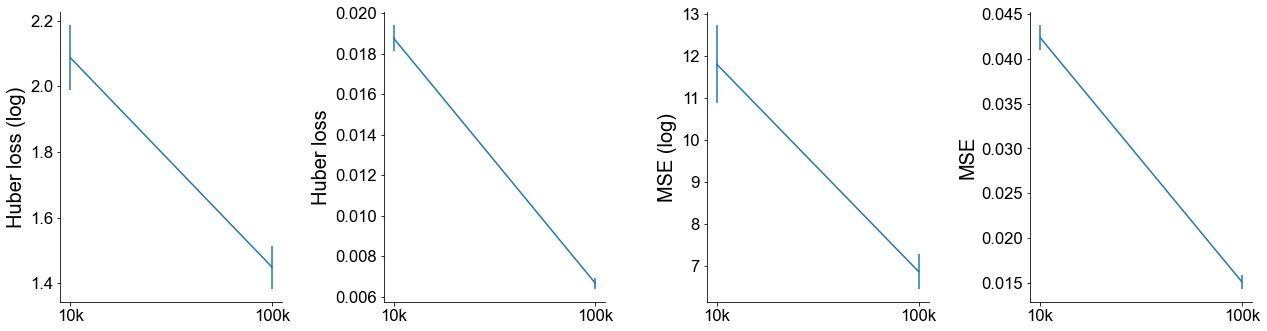

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(18, 5), sharex=True)
labels = ["Huber loss (log)", "Huber loss", "MSE (log)", "MSE"]

for idx, m in enumerate(metrics):
    plt.sca(ax[idx])
    plt.errorbar(["10k", "100k"], m.mean(0), m.std(0)/np.sqrt(10))
    plt.ylabel(labels[idx])
plt.tight_layout()